In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [13]:
plt.style.use('ggplot')

We start by first defining our ports to the accompanying directories

In [3]:
# hard-codded to match working directory of RA
inputDir = '/home/rcerxr21/DesiWork/VRP_GIT/Input/'
tempDir = '/home/rcerxr21/DesiWork/VRP_GIT/Temp/'
outDir = '/home/rcerxr21/DesiWork/VRP_GIT/Output/'

We then read in all of our existing data variables that will be used to visualize empircal trends

In [4]:
# data for all economic calender releases and annoucments
economicData = pd.read_csv(tempDir+'pythonTemps/structData/ecoData.csv')

# data concerned with computing the variance risk premia
vrp = pd.read_csv(tempDir+'pythonTemps/varRiskPremium/vrp.csv')

# implied volatility data taken using a black-scholes vol model 
impVol = pd.read_csv(tempDir+'pythonTemps/structData/blackVol.csv')

# forecasted realized volatility from GARCH model
realVol = pd.read_csv(tempDir+'pythonTemps/structData/blackVol.csv')

# interest rate regimes low/high corresponding to 2% greater/less than
highRateRegime = pd.read_csv(tempDir+'pythonTemps/structData/highIR.csv')
lowRateRegime = pd.read_csv(tempDir+'pythonTemps/structData/lowIR.csv')

In [5]:
# corresponding list of economic variables and thier 'real' names
economicVars = {'NFP TCH Index':'Change in Non-farm payrolls', 'INJCJC Index':'Initial Jobless Claims',
                'FDTR Index':'FOMC Rate Decison','GDP CQOQ Index':'GDP Annualized QoQ','CPI CHNG Index':'CPI MoM',
                'NAPMPMI Index':'ISM Manufacturing','CONSSENT Index':'U. of Mich. Sentiment',
                'USURTOT Index':'Unemployment Rate','RSTAMOM Index':'Retail Sales Advance MoM',
                'PCE CMOM Index':'PCE Core Deflator MoM'}

swaptions = {'USSV0C2Curncy':'3m2y','USSV0F2Curncy':'6m2y','USSV022Curncy':'24m2y','USSV012Curncy':'12m2y',
             'USSV0C5Curncy':'3m5y','USSV0F5Curncy':'6m5y','USSV015Curncy':'12m5y','USSV025Curncy':'24m5y', 
             'USSV0C10Curncy':'3m10y','USSV0F10Curncy':'6m10y', 'USSV0110Curncy':'12m10y',
             'USSV0210Curncy':'24m10y'}

Some helper functions we will need to quickly filter and reduce larger dataframes to manageable slices

In [6]:
def matchingError(eco, measure, window:int=1):
    """
    Finds the intersection between both macro economic fields and the 
    implied volatility/varaince risk premia levels provided

    :param: eco   -> type table
          Economic annoucments that track a particular event
    :param: measure -> type table
          Target variable measure to track against economic event
    :param: window -> type int
          The number of periods to lookback, e.g. 1 = 1-day
    """
    
    dateWindow = measure.columns[0] 
    
    # checks annoucment dates against measure date
    postAnnoucement = measure[np.isin(measure[dateWindow], eco.DateTime)][dateWindow].apply(pd.to_datetime)
    
    # checks window-lookback provided filtered ranged of annoucments 
    preAnnoucement = measure[np.isin(measure[dateWindow].apply(pd.to_datetime), 
                                    postAnnoucement.apply(
                                        lambda x:x-timedelta(days=window)
                                    ))][dateWindow].apply(pd.to_datetime)
    
    # find intersection of each timeseries
    target = set(postAnnoucement) & set(preAnnoucement.apply(lambda x:x+timedelta(days=window)))
    target = pd.Series(list(target))
    
    # deterime pre and post ranges from provided target range
    post = target
    pre = target.apply(lambda x: x-timedelta(days=window))
    
    # returns the pre/post data allocation
    return pre, post


def differenceSplit(measure, preDate, postDate):
    """
    Computing the volatility difference between pre/post annoucements
    as well as the filtered economic data 
    
    :param: base       -> type table
          Economic annoucments that track a particular event
    :param: target     -> type table
          Target variable measure to track against economic event
    :param: targetDate -> type datetime array
           Intersecting dates for variables vectors 
    """
    
    dateWindow = measure.columns[0] 
    
    # assign pre/post annoucement range for volatility measure
    pre = measure[np.isin(measure[dateWindow].apply(pd.to_datetime), preDate)]
    post = measure[np.isin(measure[dateWindow].apply(pd.to_datetime), postDate)]
    
    # compute difference across dataframe matrix 
    diff = post[post.columns[1:]].values - pre[pre.columns[1:]].values
    diff = pd.DataFrame(diff, index=postDate)
    diff.columns = measure.columns[1:]
    
    return diff

We begin by examing the forecast standard deviation buckets by percentile, examining extreme values **10th, 25th, 75th, 90th** to remove idiosyncrasies that are more prevalent in “medium” term buckets. Below we examine the effect of one event on changes to variance risk premium (VRP), implied volatility and realized volatility on average over a 1-day window **(EOD-pre-announcement to EOD-of-announcement)**. 

In [20]:
# we initialize the event and dataset being used to examine
event = 'NFP TCH Index'; # data = impVol

lowEco = economicData[(economicData.Ticker == event) & np.isin(economicData.DateMod, lowRateRegime.DateMod)]
highEco = economicData[(economicData.Ticker == event) & np.isin(economicData.DateMod, highRateRegime.DateMod)]

**NOTE: These figures are not consistent with those generated in MATLAB**. 

We examine persistent positive changes in VRP as we increase uncertainty for each economic forecast, this is amplified during **low interest rate environments (>2%)**. We reason that as uncertainty rises, implied volatility will tend to decrease sharply post- announcement, having increased in the lead up to announcement. We also examine that shifts tend to be larger on average during low-interest rate environments relative to high-interest rate.

We also see expected movement in implied volatility changes, with implied volatiity levels decreasing post annoucement window. With greater movement in low rate regimes relative to high rate regimes on average, with minimal deviation across uncertaintity.

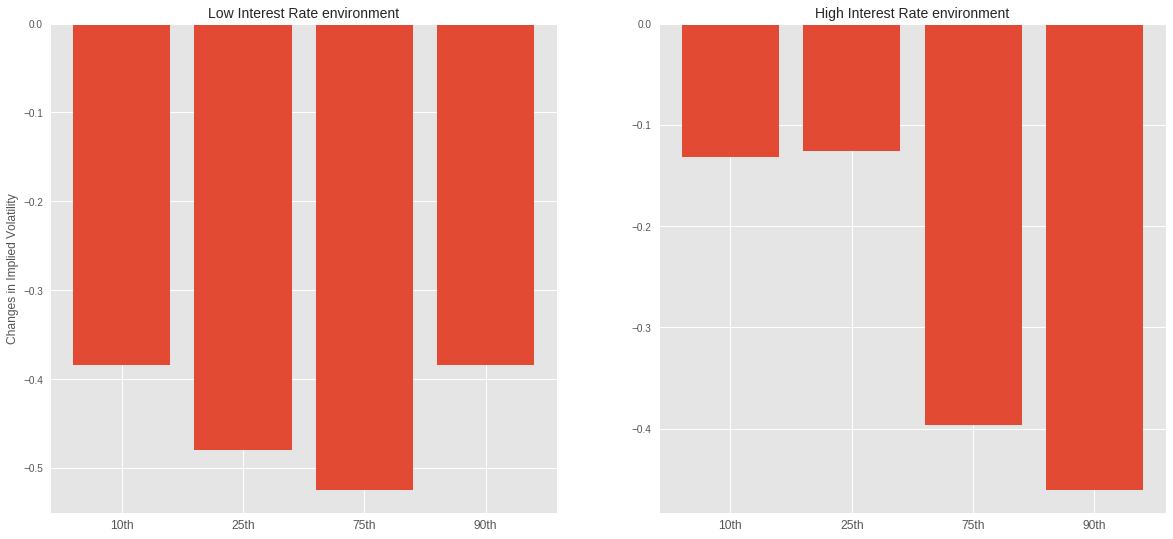

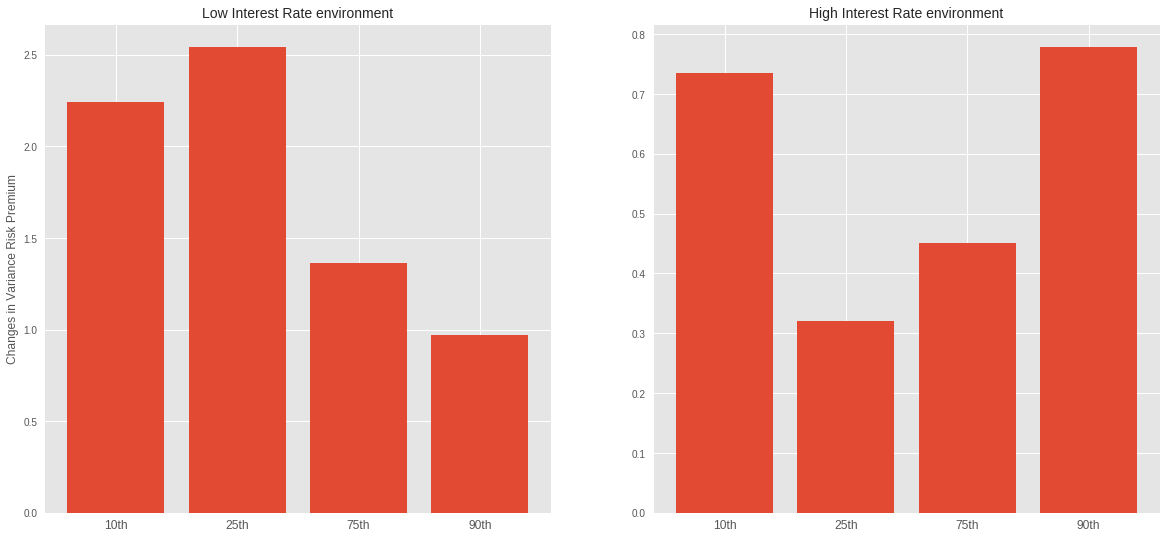

In [21]:
naming = ['Implied Volatility', 'Variance Risk Premium']

for i, data in enumerate([impVol, vrp]):
    
    # filter according to the economic event amd interest rate regime 
    lowEco = economicData[(economicData.Ticker == event) & np.isin(economicData.DateMod, lowRateRegime.DateMod)]
    highEco = economicData[(economicData.Ticker == event) & np.isin(economicData.DateMod, highRateRegime.DateMod)]
    
    # determine pre/post date range and compute the difference in data measure
    pre1, post1 = matchingError(lowEco, data)
    diff1 = differenceSplit(data, pre1, post1).mean(axis=1)

    pre2, post2 = matchingError(highEco, data)
    diff2 = differenceSplit(data, pre2, post2).mean(axis=1)
    
    # ploting functions
    fig, axes = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(9)

    axes[0].set_ylabel('Changes in {}'.format(naming[i]), size=12)
    axes[0].set_title('Low Interest Rate environment', size=14)
    axes[0].bar(['10th', '25th', '75th', '90th'], 
                [diff1[np.isin(diff1.index, lowEco[lowEco.StdDev <= lowEco.StdDev.quantile(0.10)].DateTime.apply(pd.to_datetime))].mean(),
                 diff1[np.isin(diff1.index, lowEco[lowEco.StdDev <= lowEco.StdDev.quantile(0.25)].DateTime.apply(pd.to_datetime))].mean(),
                 diff1[np.isin(diff1.index, lowEco[lowEco.StdDev >= lowEco.StdDev.quantile(0.75)].DateTime.apply(pd.to_datetime))].mean(),
                 diff1[np.isin(diff1.index, lowEco[lowEco.StdDev >= lowEco.StdDev.quantile(0.90)].DateTime.apply(pd.to_datetime))].mean()])
    axes[0].set_xticklabels(labels=['10th', '25th', '75th', '90th'],fontsize=12)
    
    axes[1].set_title('High Interest Rate environment', size=14)
    axes[1].bar(['10th', '25th', '75th', '90th'], 
                [diff2[np.isin(diff2.index, highEco[highEco.StdDev <= highEco.StdDev.quantile(0.10)].DateTime.apply(pd.to_datetime))].mean(),
                 diff2[np.isin(diff2.index, highEco[highEco.StdDev <= highEco.StdDev.quantile(0.25)].DateTime.apply(pd.to_datetime))].mean(),
                 diff2[np.isin(diff2.index, highEco[highEco.StdDev >= highEco.StdDev.quantile(0.75)].DateTime.apply(pd.to_datetime))].mean(),
                 diff2[np.isin(diff2.index, highEco[highEco.StdDev >= highEco.StdDev.quantile(0.90)].DateTime.apply(pd.to_datetime))].mean()])
    axes[1].set_xticklabels(labels=['10th', '25th', '75th', '90th'], fontsize=12)
    
    plt.show()

In [15]:
sensitvityDict = {}

# iterate through each economic event
for event in economicVars.keys():

    # filter according to the economic event amd interest rate regime 
    lowEco = economicData[(economicData.Ticker == event) & np.isin(economicData.DateMod, lowRateRegime.DateMod)]
    highEco = economicData[(economicData.Ticker == event) & np.isin(economicData.DateMod, highRateRegime.DateMod)]

    # determine pre/post date range and compute the difference in data measure
    pre1, post1 = matchingError(lowEco, vrp)
    diff1 = differenceSplit(vrp, pre1, post1).mean(axis=1)

    pre2, post2 = matchingError(highEco, vrp)
    diff2 = differenceSplit(vrp, pre2, post2).mean(axis=1)

    lowRateEnv = np.array([diff1[np.isin(diff1.index, lowEco[lowEco.StdDev <= lowEco.StdDev.quantile(0.10)].DateTime.apply(pd.to_datetime))].mean(),
                           diff1[np.isin(diff1.index, lowEco[lowEco.StdDev <= lowEco.StdDev.quantile(0.25)].DateTime.apply(pd.to_datetime))].mean(),
                           diff1[np.isin(diff1.index, lowEco[lowEco.StdDev >= lowEco.StdDev.quantile(0.75)].DateTime.apply(pd.to_datetime))].mean(),
                           diff1[np.isin(diff1.index, lowEco[lowEco.StdDev >= lowEco.StdDev.quantile(0.90)].DateTime.apply(pd.to_datetime))].mean()])

    highRateEnv = np.array([diff2[np.isin(diff2.index, highEco[highEco.StdDev <= highEco.StdDev.quantile(0.10)].DateTime.apply(pd.to_datetime))].mean(),
                            diff2[np.isin(diff2.index, highEco[highEco.StdDev <= highEco.StdDev.quantile(0.25)].DateTime.apply(pd.to_datetime))].mean(),
                            diff2[np.isin(diff2.index, highEco[highEco.StdDev >= highEco.StdDev.quantile(0.75)].DateTime.apply(pd.to_datetime))].mean(),
                            diff2[np.isin(diff2.index, highEco[highEco.StdDev >= highEco.StdDev.quantile(0.90)].DateTime.apply(pd.to_datetime))].mean()])
    
    # store the values of each response by rate regime
    sensitvityDict[event] = [np.average(lowRateEnv), np.average(highRateEnv)]


**We then examined the average VRP change across various events across all the exteme percentiles 10th, 25th, 75th, and 90th.** 

We see that on average, post annoucment VRP exhibits positive changes across economic annoucments while implied volatility exhibits a small negative change. We take note of major skew in reaction to economic annoucements, and attributes these wide variances to the material impact these annoucments have on price action for underlying swaps. The rationale being the greater the affect on price action, the greater the impact on implied and realized volatility

In [16]:
averageRange = pd.DataFrame(sensitvityDict).transpose()
averageRange.columns = ['Low Rate Regime', 'High Rate Regime']

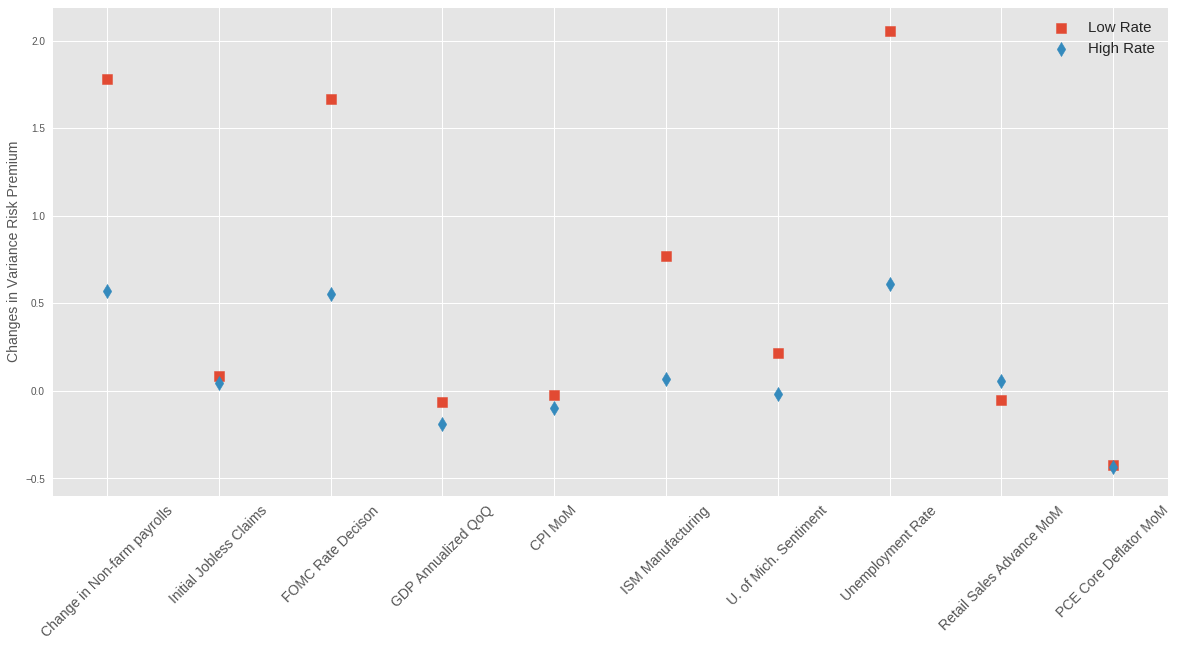

In [17]:
fig, axes = plt.subplots()

fig.set_figwidth(20)
fig.set_figheight(9)

axes.set_ylabel('Changes in {}'.format(naming[i]), size=12)
    
axes.scatter(np.arange(0, 10), averageRange['Low Rate Regime'], s=100, marker='s', label='Low Rate')
axes.scatter(np.arange(0, 10), averageRange['High Rate Regime'], s=100, marker='d', label='High Rate')
axes.set_ylabel('Changes in Variance Risk Premium', size=14)
axes.set_xticks(np.arange(0, 10))
axes.set_xticklabels(economicVars.values(), rotation=45, ha='center', size=14)

axes.legend(fontsize=15)

plt.show()